<img src="mrc.png" alt="Description de l'image" width="1400" height="100">

## <span style="color: red;">Alert FISSA Study</span>

### <span style="color: red;">Data Cleaning</span>

####  <span style="color: red;"> Data cleaning steps performed</span>

- Standardized column names using `clean_names()`.
- Renamed columns for better readability and clarity.
- Dropped irrelevant or unnecessary columns.
- Cleaned textual values:
  - Standardized to lowercase and removed extra spaces/special characters.
  - Replaced missing values (`n/a`, `?`, `unknown`, etc.) with `NaN`.
  - Parsed valid date strings to the `YYYY-MM-DD` format.
- Created a new `country` variable extracted from patient IDs.
- Created an `age` variable based on date of birth and participation date.
- Removed duplicate rows based on patient ID.
- Inspected missing values (count and proportion per variable).
- Imputed missing values in the dataset
- Saved the cleaned dataset to a new CSV file 


#### <span style="color: red;"> Load Packages</span>

In [46]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns  
import missingno as msn   
import janitor
import re     
from dateutil import parser
# Install local package using "pip install -e . --config-setting editable_mode=compat"
#import src  
#from src.clean import load_data_and_dict       
from collections import Counter

#### <span style="color: red;">Load the dataset</span>

In [47]:
# Load the west africa data
df = pd.read_excel('/Users/asani/Downloads/HDWRA/alerrt_fissa/Database fissa - Gambie.xlsx')

dic = pd.read_csv('/Users/asani/Downloads/HDWRA/alerrt_fissa/alert_fissa_gambia_datadictionary.csv',  low_memory=False)

# Shape of the data
print(f"Shape of the data: {df.shape}")

Shape of the data: (2120, 1784)


**The Gambia dataset contains 2120 rows, representing the number of observations, and  1784  columns, representing the number of variables.**

####  <span style="color: red;"> Fisrt few rows of the dataset</span>

In [48]:
# Display first 5 rows of the dataset
display(df.head()) 

,age_group,Region,Site_reel,id_participant,redcap_repeat_instrument,redcap_repeat_instance,fievre,faisabilite_contact,age˂2mois,hospt_14derniers_jours,...,prov_trt_other,pres_trt_n,prov_trt_n,trt_dup,trt_forms,covid,parasitic,bacterial,hosp_inc,hosp_any
0,0.0,Afrique_ouest,GM,GMFJ0001,Eligibility,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,Afrique_ouest,GM,GMFJ0001,medical_imaging,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,Afrique_ouest,GM,GMFJ0001,hospitalisation,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,Afrique_ouest,GM,GMFJ0001,hospitalisation,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,Afrique_ouest,GM,GMFJ0001,hospitalisation,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



####  <span style="color: red;"> Clean empty columns and rows</span>


In [49]:
# Drop empty columns
df = df.dropna(axis=1, how='all')

# Drop empty rows 
df = df.dropna(axis=0, how='all')

# Print the new shape of the dataset
print(f"New shape of the dataset: {df.shape}")

New shape of the dataset: (2120, 1313)


In [50]:
# # afficher toutes les colonnes de mon dataframe commencant par tou
# for col in df.columns:
#     if col.startswith('Peau'):
#         print(col)

In [51]:
# for col in df.columns:
#     if "Thora" in col:
#         print(col)

**471 empty columns have been dropped. The Gambia dataset now contains 2120 rows and 1313 columns.**



####  <span style="color: red;"> Resolve duplicate column names</span>


In [52]:
# Create a list of unique column names by appending suffixes to duplicates
new_columns = []
seen = {}

for col in df.columns:
     if col not in seen:
        seen[col] = 0
        new_columns.append(col)
     else:
         seen[col] += 1
         new_columns.append(f"{col}.{seen[col]}")

# Assign the new column names to the DataFrame
df.columns = new_columns

# Display duplicate column names
counts = Counter(df.columns)
duplicates = [col for col, count in counts.items() if count > 1]
print(duplicates)

[]


####  <span style="color: red;">Age calculation based on multiple columns</span>

In [ ]:
# Convert date columns
df['date_inc'] = pd.to_datetime(df['date_inc'], errors='coerce')
df['date_naissance'] = pd.to_datetime(df['date_naissance'], errors='coerce')

# Calculate age from date of birth
df['age_from_dob'] = ((df['date_inc'] - df['date_naissance']).dt.days) / 365.25

# Ensure numeric conversion for all relevant age columns
for col in ['age', 'age_mois', 'age_annee', 'age_enfant_mois', 'age_année']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Compute age from months (convert to years)
df['age_from_months'] = df[['age_mois', 'age_enfant_mois']].max(axis=1) / 12

# Compute age from year fields (take the maximum)
df['age_from_years'] = df[['age_annee', 'age_année']].max(axis=1)

# Combine age information into a single column 'age_final'
df['age_final'] = df['age_from_dob'].combine_first(df['age'])
df['age_final'] = df['age_final'].combine_first(df['age_from_years'])
df['age_final'] = df['age_final'].combine_first(df['age_from_months'])

# Round to 2 decimals
df['age_final'] = df['age_final'].round(0)

# Drop intermediate columns used for computing age
columns_to_drop = ['date_naissance', 'age', 'age_mois', 'age_en', 'age_annee', 'age_enfant_mois', 'age_année',
                   'age_connu', 'age_from_dob', 'age_from_months', 'age_from_years', 'date_naissance_connue'
]

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Rename 'age_final' to 'age'
df.rename(columns={'age_final': 'age'}, inplace=True)

####  <spanA style="color: red;"> Data cleaning pipeline </span>

In [ ]:
# Cleaning function
def clean_column(val):
    if pd.isna(val):
        return val
    val = str(val).strip()
    
    # Detect and normalize valid date strings
    try:
        parsed_date = parser.parse(val, fuzzy=False)
        return parsed_date.strftime('%d-%m-%Y')
    except (ValueError, TypeError):
        pass  

    val = val.lower()
    
    # Replace invalid or missing values
    if re.match(r"^\s*$|^_+$|^(n/a|na|null|none|unknown|\?)$", val, re.IGNORECASE):
        return pd.NA

    # Normalize text values
    val = re.sub(r"\s+", "_", val)         
    #val = re.sub(r"[^a-zA-Z0-9_]", "", val)  
    return val

# Cleaning pipeline
df = (
    df
    .clean_names()
    .apply(lambda col: col.map(clean_column) if col.dtype == "object" else col)
    #.drop_duplicates(subset='q1_pre_tb')
)

# Display the cleaned df
display(df.head())

,age_group,region,site_reel,id_participant,redcap_repeat_instrument,redcap_repeat_instance,fievre,faisabilite_contact,age˂2mois,hospt_14derniers_jours,...,rais_oppos_fam_1,rais_oppos_fam_2,rais_oppos_fam_3,rais_oppos_pat_1,rais_oppos_pat_2,rais_oppos_pat_3,rempli_2,dat_rempli_7,conclusion_form_complete,age
0,0.0,afrique_ouest,gm,gmfj0001,eligibility,NaN,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,antouman_jagne,02-03-2020,2.0,1.0
1,0.0,afrique_ouest,gm,gmfj0001,medical_imaging,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,afrique_ouest,gm,gmfj0001,hospitalisation,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,afrique_ouest,gm,gmfj0001,hospitalisation,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,afrique_ouest,gm,gmfj0001,hospitalisation,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <span style="color: red;">Missing data overview</span>

In [ ]:
# Inspect Missing Values
missing_values = df.isnull().sum()
missing_proportions = missing_values / len(df)
missing_df = pd.concat([missing_values, missing_proportions], axis=1)

missing_df.columns = ['Number of Missing Values', 'Proportion of Missing Values']
missing_df = missing_df.sort_values('Proportion of Missing Values', ascending=False)

pd.reset_option('display.max_rows', None)
display(missing_df)

,Number of Missing Values,Proportion of Missing Values
autr_sympt_1_4,2119,0.999528
taille_3,2119,0.999528
fiev_jaun_1,2119,0.999528
pneumococ_1,2119,0.999528
heamoph_infl_1,2119,0.999528
...,...,...
age_group,6,0.002830
region,0,0.000000
redcap_repeat_instrument,0,0.000000
id_participant,0,0.000000



#### <span style="color: red;">Visualize missingness statistics</span>

In [ ]:
# # Calculate missing values and proportions
# missing_values = df.isnull().sum()
# missing_proportions = missing_values / len(df)

# # Combine into a single DataFrame
# missing_df = pd.concat([missing_values, missing_proportions], axis=1)
# missing_df.columns = ['Missing Count', 'Missing Proportion']
# missing_df = missing_df.sort_values('Missing Proportion', ascending=False)

# # Filter to only show columns with missing values
# missing_df = missing_df[missing_df['Missing Count'] > 0]

# # Plot
# plt.figure(figsize=(14, 10))
# sns.barplot(
#     data=missing_df.reset_index(),
#     y='index',
#     x='Missing Proportion',
#     hue='index',            
#     palette='Reds_r',
#     dodge=False,
#     legend=False          
# )
# plt.xlabel('Proportion of Missing Values')
# plt.ylabel('Column Name')
# plt.title('Proportion of Missing Data by Column')
# plt.tight_layout()
# plt.grid(axis='x', linestyle='--', alpha=0.5)
# plt.show()


#### <span style="color: red;">Influenza and Arbovirus Classification</span>

In [ ]:
# Keep only rows where fever is present
df = df[df['fievre'] == 1] 

# drop missing data in dur_sympt column
df = df.dropna(subset=['dur_sympt'])

# -------------------------------
# Influenza-like illness
# -------------------------------
df['influenza'] = (
    ((df['thorax_1'] == 1) |  # thorax_1 = cough
     (df['orl_6'] == 1)) &    # orl_6 = sore throat (dysphagia)
    (df['dur_sympt'] <= 10)   # dur_sympt = duration of symptoms (days)
).astype(int)

# -------------------------------
# Arbovirus
# -------------------------------
respiratory_symptoms = (
    (df['thorax_1'] == 1) |  # thorax_1 = cough
    (df['thorax_2'] == 1) |  # thorax_2 = dyspnea (shortness of breath)
    (df['thorax_4'] == 1)    # thorax_4 = chest pain
)

arbovirus_cols = [
    'syst_nev_1',  # headache
    'muscl_1',     # arthralgia (joint pain)
    'muscl_2',     # myalgia (muscle pain)
    'peau_1',      # skin rash
    'orl_5',       # retro-orbital pain (eye pain)
    'peau_3',      # purpura (skin hemorrhage spots)
    'thorax_3'     # thorax_3: hemoptysis (coughing up blood)
]

symptom_count = df[arbovirus_cols].eq(1).sum(axis=1)

df['arbovirus'] = (
    (~respiratory_symptoms) &  
    (symptom_count >= 2)       
).astype(int)

df['arbovirus'].value_counts(), df['influenza'].value_counts()

(arbovirus
 0    316
 1     10
 Name: count, dtype: int64,
 influenza
 0    201
 1    125
 Name: count, dtype: int64)

In [ ]:
# Save the cleaned data as a csv file
df.to_csv('/Users/asani/Downloads/HDWRA/alerrt_fissa/cleaned_fissa_gambia_data.csv', index=False)

In [ ]:
import pandas as pd

# 1. Convert the incident date column to datetime format
df['date_inc'] = pd.to_datetime(df['date_inc'], errors='coerce')

# 2. Aggregate daily counts for influenza and arbovirus
daily_counts = (
    df.groupby('date_inc')[['influenza', 'arbovirus']]
      .sum()                     # Sum cases per day
      .reset_index()             # Reset index for plotting
)

# 3. Preview the aggregated data
print(daily_counts.head())

    date_inc  influenza  arbovirus
0 2020-02-07          0          0
1 2020-02-10          0          0
2 2020-02-11          0          1
3 2020-02-12          0          0
4 2020-02-13          2          0


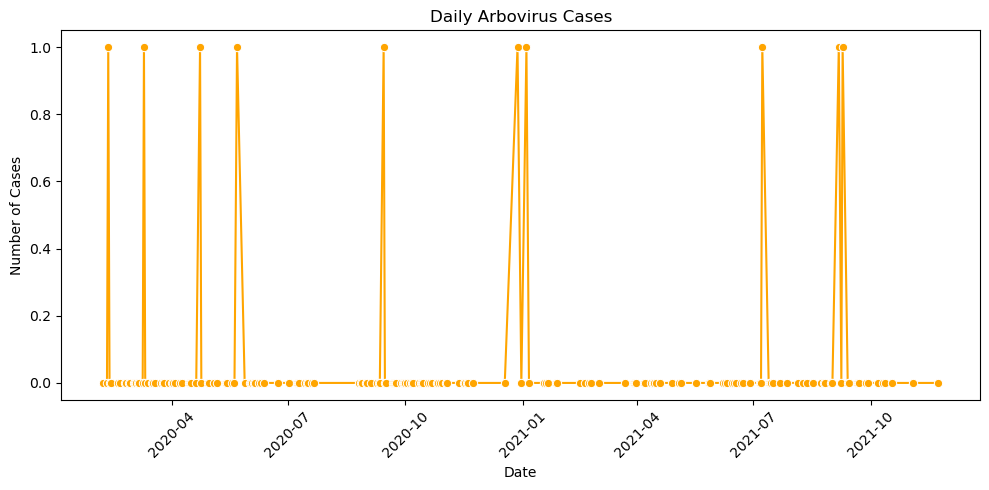

In [ ]:
arbovirus_daily = df.groupby('date_inc')['arbovirus'].sum().reset_index()
arbovirus_daily.rename(columns={'arbovirus': 'arbovirus_cases'}, inplace=True)

plt.figure(figsize=(10,5))
sns.lineplot(data=arbovirus_daily, x='date_inc', y='arbovirus_cases', marker='o', color='orange')
plt.title('Daily Arbovirus Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

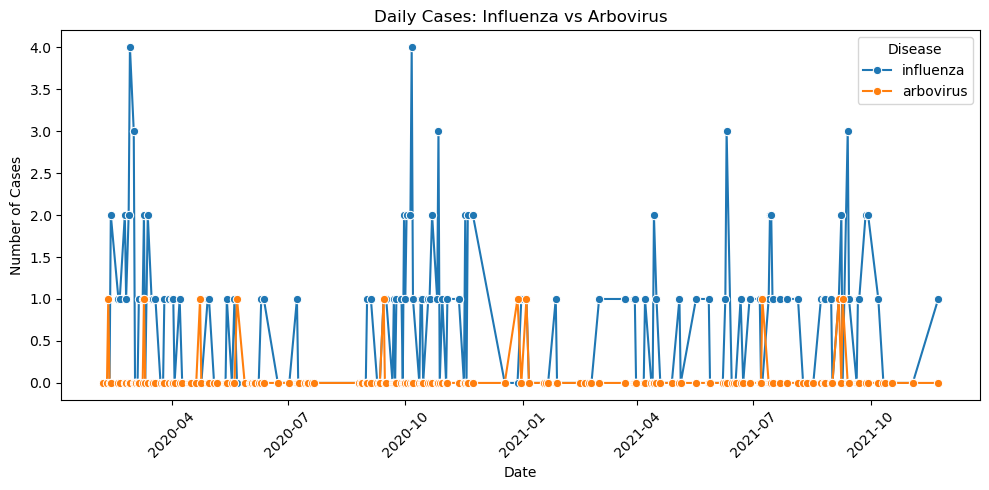

In [ ]:
comparison_daily = df.groupby('date_inc')[['influenza', 'arbovirus']].sum().reset_index()
comparison_daily = comparison_daily.melt(id_vars='date_inc', 
                                         value_vars=['influenza', 'arbovirus'],
                                         var_name='disease', value_name='cases')

plt.figure(figsize=(10,5))
sns.lineplot(data=comparison_daily, x='date_inc', y='cases', hue='disease', marker='o')
plt.title('Daily Cases: Influenza vs Arbovirus')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend(title='Disease')
plt.tight_layout()
plt.show()

/var/folders/c2/9l1x0mm13m5b9xdbjcms08sc0000gn/T/ipykernel_4280/681914727.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sexe_label', palette='pastel')


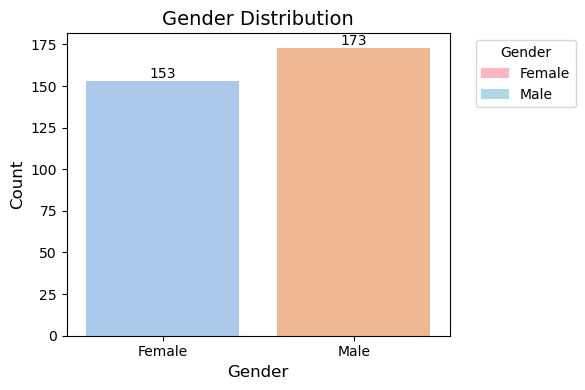

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Remplacer codes par labels
df['sexe_label'] = df['sexe'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sexe_label', palette='pastel')

plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Ajouter les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom')

# Créer une légende manuelle si besoin
legend_elements = [Patch(facecolor='lightpink', label='Female'),
                   Patch(facecolor='lightblue', label='Male')]
plt.legend(handles=legend_elements, title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


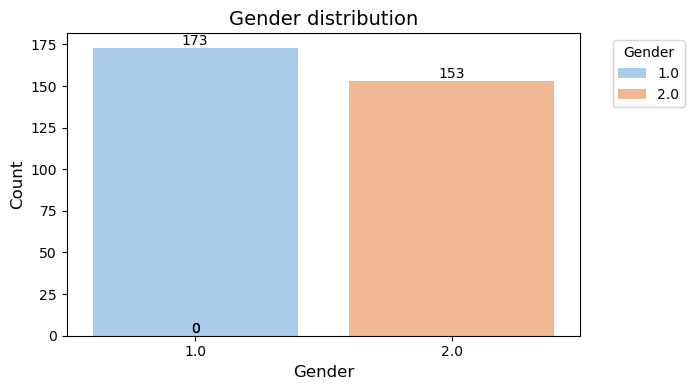

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sexe', hue='sexe', palette='pastel')

plt.title('Gender distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show counts above bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom')

plt.tight_layout()
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left')  # Légende hors du graphe
plt.show()


In [ ]:
df['sexe'].value_counts()

sexe
1.0    173
2.0    153
Name: count, dtype: int64

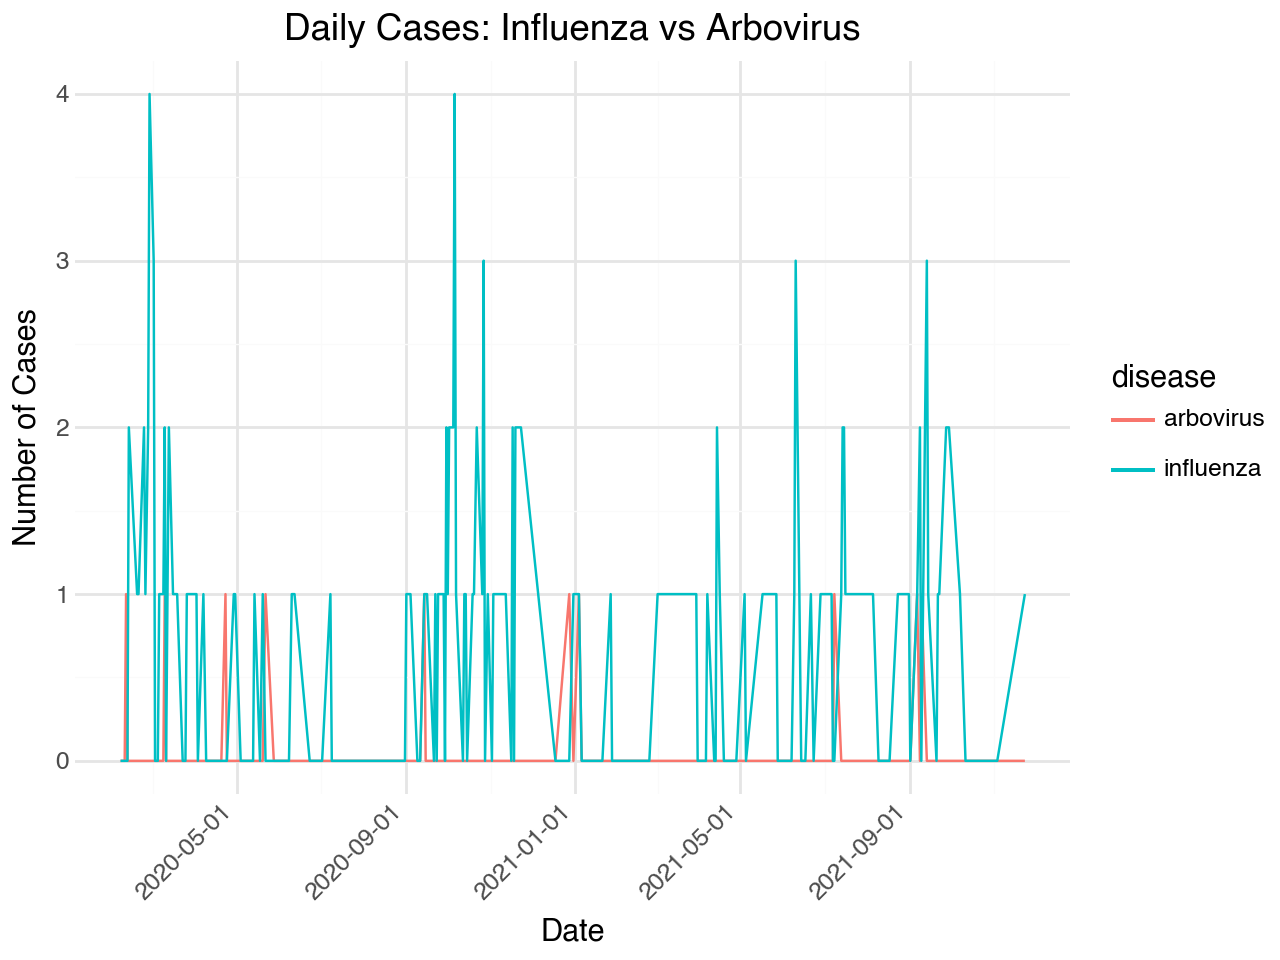

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, element_text

# Using the melted comparison_daily dataframe
(
    ggplot(comparison_daily, aes(x='date_inc', y='cases', color='disease'))
    + geom_line()
    + labs(title='Daily Cases: Influenza vs Arbovirus', x='Date', y='Number of Cases')
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

####  <span style="color: red;"> Save the cleaned dataset to a new CSV file</span>

In [ ]:
# Save the cleaned dataset
#dfwa.to_csv('cleaned_tb_dataset.csv', index=False)